# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем все необходимые библиотеки и структуры. Загрузим и изучим данные.

In [2]:
pip install wordcloud

     |████████████████████████████████| 458 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.corpus import stopwords as nltk_stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer; nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
%matplotlib inline
import joblib
import warnings; warnings.filterwarnings("ignore");
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import MaxAbsScaler, Normalizer

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
!cp /datasets/fashion_mnist/train_features.npy--archive

cp: missing destination file operand after '/datasets/fashion_mnist/train_features.npy--archive'
Try 'cp --help' for more information.


In [23]:
!cp --archive /datasets/fashion_mnist/train_features.npy [-T]

cp: preserving times for '[-T]': Input/output error


In [25]:
!cp --backup /datasets/fashion_mnist/train_features.npy

cp: missing destination file operand after '/datasets/fashion_mnist/train_features.npy'
Try 'cp --help' for more information.


In [4]:
cp --help

Usage: cp [OPTION]... [-T] SOURCE DEST
  or:  cp [OPTION]... SOURCE... DIRECTORY
  or:  cp [OPTION]... -t DIRECTORY SOURCE...
Copy SOURCE to DEST, or multiple SOURCE(s) to DIRECTORY.

Mandatory arguments to long options are mandatory for short options too.
  -a, --archive                same as -dR --preserve=all
      --attributes-only        don't copy the file data, just the attributes
      --backup[=CONTROL]       make a backup of each existing destination file
  -b                           like --backup but does not accept an argument
      --copy-contents          copy contents of special files when recursive
  -d                           same as --no-dereference --preserve=links
  -f, --force                  if an existing destination file cannot be
                                 opened, remove it and try again (this option
                                 is ignored when the -n option is also used)
  -i, --interactive            prompt before overwrite (overrides a previo

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
data.text

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159287    ":::::And for the second time of asking, when ...
159288    You should be ashamed of yourself \n\nThat is ...
159289    Spitzer \n\nUmm, theres no actual article for ...
159290    And it looks like it was actually you who put ...
159291    "\nAnd ... I really don't think you understand...
Name: text, Length: 159292, dtype: object

In [7]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


Посмотрим на распределение классов.

In [8]:
display(data['toxic'].value_counts())

0    143106
1     16186
Name: toxic, dtype: int64

In [9]:
ratio = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
ratio

8.841344371679229

Данные несбалансированные, будет учитывать это на этапе обучения моделей.

Удалим столбец 'Unnamed: 0', поскольку он нам не нужен.

In [10]:
del data['Unnamed: 0']

Напишем функцию clear_text(text), которая оставит в тексте только кириллические символы и пробелы. На вход она принимает текст, а возвращает очищенный текст, дополнительно уберем лишние пробелы. После функция очищенный текст лемматизирует с помощью WordNetLemmatizer().

In [11]:
lem = WordNetLemmatizer()

In [12]:
def clear_text(text):
    cl_text = ' '.join(re.sub(r'[^a-zA-Z]', " ", text).lower().split())
    word_list = nltk.word_tokenize(cl_text)
    lemm_text = ' '.join([lem.lemmatize(w, 'v') for w in word_list])
    return lemm_text

data['lemm_text'] = data['text'].apply(clear_text)
print(data.lemm_text[:5])

0    explanation why the edit make under my usernam...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i can t make any real suggestions on impr...
4    you sir be my hero any chance you remember wha...
Name: lemm_text, dtype: object


In [13]:
data['lemm_text'] = data['text'].apply(clear_text)
data = data.drop(['text'], axis=1)

In [14]:
fdist = FreqDist(data['lemm_text'])

In [15]:
fdist.most_common(5)

[('january', 21),
 ('thank you for experiment with wikipedia your test work and it have be revert or remove please use the sandbox for any other test you may want to do take a look at the welcome page to learn more about contribute to our encyclopedia talk',
  19),
 ('jun utc', 18),
 ('please stop if you continue to vandalize page you will be block from edit wikipedia',
  18),
 ('precede unsigned comment add by', 16)]

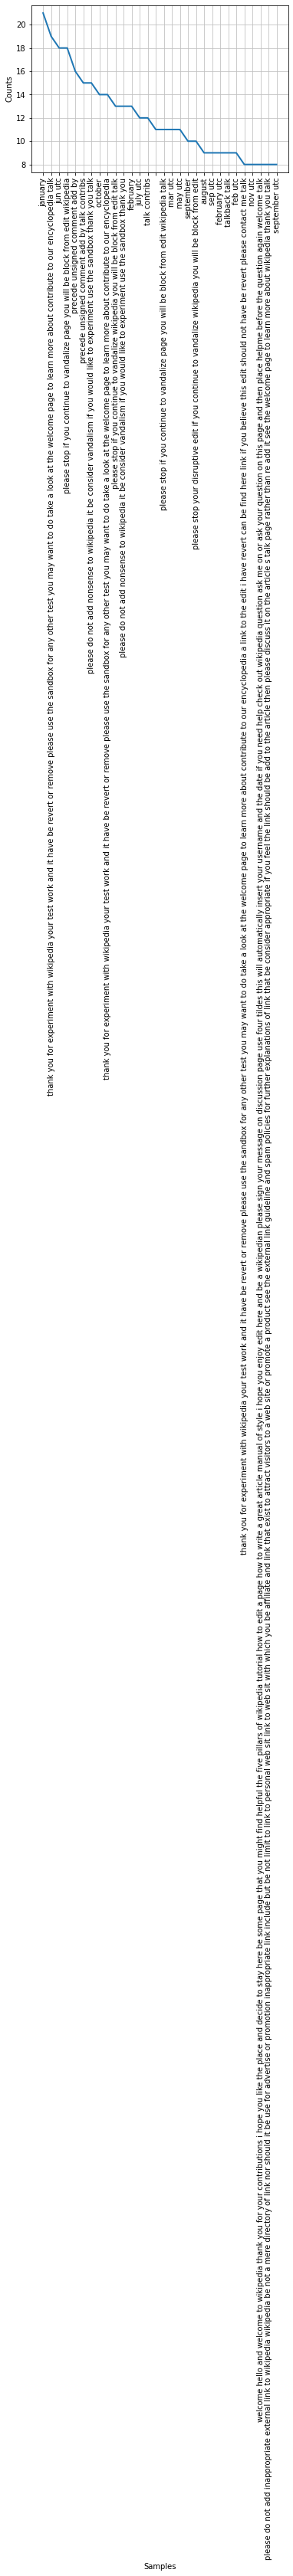

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [16]:
fdist.plot(30,cumulative=False)

In [17]:
text_raw = " ".join(data['lemm_text'])

In [18]:
wordcloud = WordCloud().generate(text_raw)

(-0.5, 399.5, 199.5, -0.5)

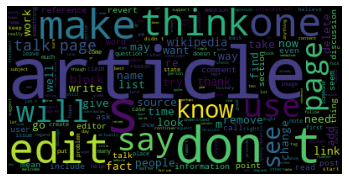

In [19]:
plt.imshow(wordcloud)
plt.axis('off')

**Вывод по шагу 1**

На первом шаге произведена загрузка данных и их подготовка для обучения моделей.

1. Перед нами DataFrame в из 3 столбцов с данными и 159292 строк, содержащий текстовую информацию.
2. Дубликатов и пропусков нет.
3. Выявлен дисбаланс классов 1:8, что будет учитываться при обучении моделей.
4. Удален столбец 'Unnamed: 0'.
5. Текст лемматизирован и очищен.

## Обучение

Разделим датасет на features_train, features_valid, target_train, target_valid, features_test и target_test. Сделаем проверку методом shape.

In [20]:
target = data['toxic']
features = data.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=42)

In [21]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(127433, 1) (127433,)
(15929, 1) (15929,)
(15930, 1) (15930,)


Добавим список стоп-слов.

In [22]:
nltk.download('stopwords') 
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим счётчик, указав в нём стоп-слова.

In [23]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Посчитаем TF-IDF для корпуса текстов, функцией fit_transform().

In [24]:
features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
features_valid = count_tf_idf.transform(features_valid['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])

In [25]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(127433, 136264) (127433,)
(15929, 136264) (15929,)
(15930, 136264) (15930,)


In [26]:
%%time
best_model_random_forest = None
best_est_random_forest = 0
best_depth_random_forest = 0
best_f1_random_forest = 0
for est in range(2,51,10):
    for depth in range(2,10):
        model_RF = RandomForestClassifier(random_state = 42, n_estimators = est, max_depth = depth, n_jobs=-1)
        model_RF.fit(features_train,target_train)
        prediction_valid_random_forest = model_RF.predict(features_valid)
        f1_random_forest = f1_score(target_valid, prediction_valid_random_forest)
        if best_f1_random_forest < f1_random_forest:
            best_model_random_forest = model_RF
            best_depth_random_forest = depth
            best_est_random_forest = est
            best_f1_random_forest = f1_random_forest
            
print("f1_score наилучшей модели RandomForestClassifier на валидационной выборке:", best_f1_random_forest) 

f1_score наилучшей модели RandomForestClassifier на валидационной выборке: 0.0297951582867784
CPU times: user 25.4 s, sys: 740 ms, total: 26.2 s
Wall time: 26.3 s


In [27]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=42)

In [28]:
df_train.shape, df_test.shape

((119469, 2), (39823, 2))

In [29]:
df_train.lemm_text

17183     the source be also not acceptable for reason a...
123920    etaonash just like the rest of the editors you...
12358     do you remove my post on the discussion page f...
101443    aggressive edit please discuss with me any dis...
29758     really good contributor bullshit the cabal dis...
                                ...                        
119879    first of all editor theredpenofdoom be not a m...
103694                             and decide to become gay
131932    john bull vs adolf hitler look at the picture ...
146867    october you have a lot to learn about the way ...
121958    i m sorry tip the deduction be obvious and wro...
Name: lemm_text, Length: 119469, dtype: object

In [30]:
%%time

pipe = Pipeline([
    ('tidf', TfidfVectorizer()),
    ('score', LogisticRegression(C=2, class_weight={0:1, 1:8}, 
                                 max_iter=1000, penalty='l2', random_state=42))
])

params = {
   "tidf__min_df": [1e-4, 1e-5, 1e-6],
   "score__C": [2, 5, 10]
}

gcsv = GridSearchCV(pipe, param_grid=params, scoring='f1', verbose=5)
gcsv.fit(df_train.lemm_text, df_train.toxic)

y_hat = gcsv.predict(df_test.lemm_text)

f1_test = f1_score(df_test.toxic, y_hat)

print("f1_score наилучшей модели LogisticRegression CV: ", gcsv.best_score_)
print("f1_score LogisticRegression на тестовой выборке: ", f1_test) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ................score__C=2, tidf__min_df=0.0001; total time=  40.1s
[CV 2/5] END ................score__C=2, tidf__min_df=0.0001; total time=  43.9s
[CV 3/5] END ................score__C=2, tidf__min_df=0.0001; total time=  46.3s
[CV 4/5] END ................score__C=2, tidf__min_df=0.0001; total time=  49.7s
[CV 5/5] END ................score__C=2, tidf__min_df=0.0001; total time=  34.7s
[CV 1/5] END .................score__C=2, tidf__min_df=1e-05; total time= 1.0min
[CV 2/5] END .................score__C=2, tidf__min_df=1e-05; total time= 1.4min
[CV 3/5] END .................score__C=2, tidf__min_df=1e-05; total time=  58.6s
[CV 4/5] END .................score__C=2, tidf__min_df=1e-05; total time=  48.2s
[CV 5/5] END .................score__C=2, tidf__min_df=1e-05; total time=  57.9s
[CV 1/5] END .................score__C=2, tidf__min_df=1e-06; total time= 1.1min
[CV 2/5] END .................score__C=2, tidf__m

**Вывод по шагу 2**

Данные разделены на обучающую, валидационную и тестовую выборки.  
Обучены модели LogisticRegression и RandomForestClassifier.  
Наилучший результат F1 показала LogisticRegression.

In [31]:
dummy_prediction_1 = [1 for i in range(len(target_test))]

In [32]:
dummy_f1_score_1 = f1_score(dummy_prediction_1, target_test.reset_index(drop=True)) 
dummy_f1_score_1

0.18420152741365553

In [33]:
dummy_prediction_0 = [0 for i in range(len(target_test))]

In [34]:
dummy_f1_score_0 = f1_score(dummy_prediction_0, target_test.reset_index(drop=True)) 
dummy_f1_score_0

0.0

In [35]:
prediction_test_random_forest = best_model_random_forest.predict(features_test)
f1_test_random_forest = f1_score(target_test, prediction_test_random_forest)
print("f1 RandomForestClassifier на тестовой выборке", f1_test_random_forest)

f1 RandomForestClassifier на тестовой выборке 0.0243605359317905


## Выводы

На первом этапе данные были изучены и подготовлены. Проведена лемматизация и работа с регулярными выражениями.
На втором этапе, учитывая дисбаланс классов, обучены модели LogisticRegression и RandomForestClassifier.
Выбрана лучшая модель на валидационной выборке и проведено финальное тестирование модели на тестовой выборке. Проведена оценка адекватности модели.

На финальном тестировании метрика F1 у LogisticRegression составила 0.77.